<h3> <b> Submission Details:
<ul>
<li> Name : Krutarth Bhatt
<li> Current Occupation : MS in Computer Science Student at Arizona State University. 
<li> Submitted with title: Vision Transformers with Capsule Networks for End-to-End Particle Reconstruction for CMS Experiment
<li> My <a href='https://www.linkedin.com/in/krutarth-bhatt/'>LinkedIn<a> 

<h3> <b> For this task I have used data from 2 files provided in on the cern website those are:
<ul> 
<li> QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet
<li> QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet
</ul>
 

<h3> <b>Problems faced and their solutions:
<ul>
<li> Due to the large datasets in one file, the files cannot be loaded and opened on google colab. For this, I loaded the files in my local extracted images and labels and stored them on local and then uploaded all those data to google drivc.
<li> Another problem faced was with integration of google drive with google colab. Here google colab is not able to read files stored on google drive due to large number of files in a single folder. Solution for this I found is to store small number of images in different folders instead of populating them in one.  

<h3> <b> Approach:
<ul>
<li> Here, I have used the approach of transfer learning. I have loaded a pretrained VGG16 on imagenet dataset and used as a feature extractor.  
<li> Also, I have kept skip connections in the network so as to facilitate better flow of gradients. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content

/content


In [ ]:
ls

drive/  sample_data/  task2_imgs.zip


In [ ]:
!unzip task2_imgs.zip

In [ ]:
cd /content/drive/MyDrive/ML4Sci/Task2

/content/drive/MyDrive/ML4Sci/Task2


In [ ]:
import os
import h5py    
import numpy as np 
import pandas as pd
from sklearn.utils import shuffle
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt 
import pickle 
import cv2

In [ ]:
img_lable = pd.read_csv('Img_Label_New3.csv')
img_lable.reset_index(drop=True, inplace=True)
img_lable = img_lable[['img', 'y']]
img_lable = shuffle(img_lable)
img_lable.reset_index(drop=True, inplace=True)

img_lable

,img,y
0,task2_imgs/74/img_37216.png,1.0
1,task2_imgs/38/img_19049.png,0.0
2,task2_imgs/146/img_73173.png,0.0
3,task2_imgs/145/img_72837.png,0.0
4,task2_imgs/92/img_46274.png,1.0
...,...,...
83807,task2_imgs/12/img_6235.png,1.0
83808,task2_imgs/124/img_62138.png,0.0
83809,task2_imgs/21/img_10640.png,0.0
83810,task2_imgs/139/img_69653.png,1.0


In [ ]:
split_ratio = 0.8
train_samples = int(0.8*len(img_lable))

train_df = img_lable[:train_samples]
train_df.reset_index(drop=True, inplace=True)

test_df = img_lable[train_samples:]
test_df.reset_index(drop=True, inplace=True)

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

tf.random.set_seed(0)

In [ ]:
#Simple CNN 
class CNN_Model(Model):
  def __init__(self):
    super(CNN_Model, self).__init__()
    
    
    self.vgg_base = tf.keras.applications.vgg16.VGG16(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=(125, 125, 3),
        pooling=None,
    )
    self.vgg_base.trainable = False

    self.flatten = Flatten()

    self.do = tf.keras.layers.Dropout(0.3) 
    self.d2 = Dense(4608, activation='relu')

    self.d3 = Dense(1, activation='sigmoid')

    

  def call(self, x):
    x = self.vgg_base(x)
    x = self.flatten(x)
    
    x_ = self.d2(x)
    x += x_
    x = self.do(x)

    x = self.d3(x)

    return x

# Create an instance of the model
model = CNN_Model()

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
#Custom Metric to Get auc_roc during training 
from sklearn.metrics import roc_auc_score
def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
#Custom Data Generator 
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, data_df,
                 batch_size,
                 input_size=(125, 125, 3),
                 shuffle=True):
      
      self.data_df = data_df 

      self.batch_size = batch_size
      self.shuffle = shuffle

      self.input_size = input_size


    def __getitem__(self, index):
      x = []
      y = []
      for i in range(index*self.batch_size , (index+1)*self.batch_size):
        img = cv2.imread('/content/'+self.data_df['img'][i])
        x.append(img)
        if img is None:
          print('task2_imgs/'+self.data_df['img'][i])
        y.append(self.data_df['y'][i])

      x = np.array(x, dtype=float)
      # print(x.shape)
      y = np.array(y)

      return x, y

    def __len__(self):
      return len(self.data_df) // self.batch_size


    def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.data_df))
      if self.shuffle == True:
          np.random.shuffle(self.indexes)

#Training The Model

In [ ]:
train_gen = CustomDataGen(train_df, 512)
val_gen = CustomDataGen(test_df, 512)

In [ ]:
len(train_gen)

130

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', auroc])

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'models/task2_tf_model.ckpt',
    monitor='val_auroc',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

In [ ]:
history = model.fit(train_gen, validation_data = val_gen, epochs = 15, callbacks=[checkpoint_callback])

Epoch 1/15
130/130 [==============================] - 295s 2s/step - loss: 0.7860 - accuracy: 0.6461 - auroc: 0.7216 - val_loss: 0.5940 - val_accuracy: 0.6905 - val_auroc: 0.7629
Epoch 2/15
130/130 [==============================] - 291s 2s/step - loss: 0.5906 - accuracy: 0.6923 - auroc: 0.7566 - val_loss: 0.5758 - val_accuracy: 0.7076 - val_auroc: 0.7703
Epoch 3/15
130/130 [==============================] - 291s 2s/step - loss: 0.5814 - accuracy: 0.7004 - auroc: 0.7661 - val_loss: 0.5746 - val_accuracy: 0.7077 - val_auroc: 0.7740
Epoch 4/15
130/130 [==============================] - 291s 2s/step - loss: 0.5783 - accuracy: 0.7043 - auroc: 0.7708 - val_loss: 0.5731 - val_accuracy: 0.7092 - val_auroc: 0.7755
Epoch 5/15
130/130 [==============================] - 291s 2s/step - loss: 0.5761 - accuracy: 0.7048 - auroc: 0.7725 - val_loss: 0.5855 - val_accuracy: 0.6968 - val_auroc: 0.7760
Epoch 6/15
130/130 [==============================] - 290s 2s/step - loss: 0.5731 - accuracy: 0.7088 - au

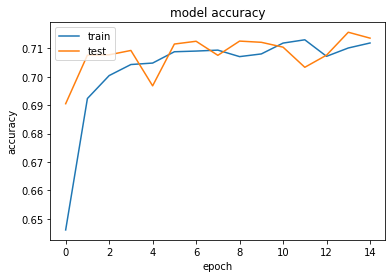

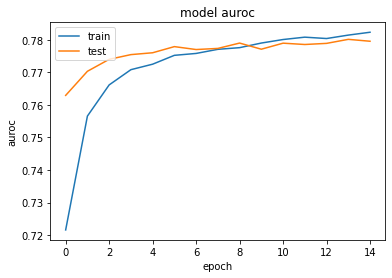

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#For AUROC
plt.plot(history.history['auroc'])
plt.plot(history.history['val_auroc'])
plt.title('model auroc')
plt.ylabel('auroc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()